<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/LIDC_cnn_feature_subgroups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [182]:
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO
# %cd ..

fatal: destination path 'LIDC_GDRO' already exists and is not an empty directory.
/content/LIDC_GDRO


In [184]:
# !git pull

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9 (delta 5), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (9/9), done.
From https://github.com/mtzig/LIDC_GDRO
   d68bac4..a2892ec  main       -> origin/main
Updating d68bac4..a2892ec
Fast-forward
 notebooks/LIDC_cnn_feature_subgroups.ipynb | 1137 ++++++++++++++++++++++++----
 train.py                                   |   58 +-
 2 files changed, 1021 insertions(+), 174 deletions(-)


In [185]:
# import os
# import torch
import pandas as pd
# import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset
from models import TransferModel
from loss import ERMLoss#, GDROLossAlt, GDROLoss
from train import train, test
from torch.optim.lr_scheduler import ReduceLROnPlateau

# import torchvision
import torch
from image_data_utils import getImages

In [186]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


#To derive an upper bound on performance, we first do clustering on entire dataset

In [238]:
nodule_id, img_data = getImages(split=False, sublabels=False, binary=False, device=DEVICE)

In [215]:
import random
shuffle_data = list(zip(*img_data, nodule_id))
random.shuffle(shuffle_data)
s_d = list(zip(*shuffle_data))
shuffle_data, shuffle_id = s_d[:2], s_d[2]

In [216]:
# dataset = NoduleDataset(*img_data)
tr = NoduleDataset(shuffle_data[0][:744],shuffle_data[1][:744])
cv = NoduleDataset(shuffle_data[0][744:],shuffle_data[1][744:])
loader = InfiniteDataLoader(tr, batch_size=128)
cv_loader = InfiniteDataLoader(cv, len(cv))

In [217]:
model = TransferModel(freeze=False, binary=False, device=DEVICE)
loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{})
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)


In [218]:
epochs = 30
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train(loader, model, loss_fn, optimizer, verbose=True)
    accuracy = test(cv_loader, model, subgrouped=False, verbose=True)
    scheduler.step(accuracy)

Epoch 1/30
Average training loss: 2.3126442193984986
Accuracy: 0.396505376344086
Epoch 2/30
Average training loss: 1.394489598274231
Accuracy: 0.46774193548387094
Epoch 3/30
Average training loss: 1.0497516512870788
Accuracy: 0.5241935483870968
Epoch 4/30
Average training loss: 0.6814910888671875
Accuracy: 0.5766129032258065
Epoch 5/30
Average training loss: 0.6534410357475281
Accuracy: 0.6088709677419355
Epoch 6/30
Average training loss: 0.5219313979148865
Accuracy: 0.553763440860215
Epoch 7/30
Average training loss: 0.42442508935928347
Accuracy: 0.581989247311828
Epoch 8/30
Average training loss: 0.32856125235557554
Accuracy: 0.581989247311828
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/30
Average training loss: 0.2844683051109314
Accuracy: 0.5806451612903226
Epoch 10/30
Average training loss: 0.24646483212709427
Accuracy: 0.6075268817204301
Epoch 11/30
Average training loss: 0.2317757487297058
Accuracy: 0.5873655913978495
Epoch 00011: reducing learning rate

# Now we extract the features

In [219]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.model.avgpool.register_forward_hook(get_activation('avgpool'))
image_tensors = next(cv_loader)[0]#torch.stack(img_data[0])
model(image_tensors)
image_features = activation['avgpool'].squeeze()


In [220]:
cols = []
for idx,id in enumerate(shuffle_id[744:]):
  cols.append([id] + image_features[idx].cpu().numpy().tolist())
lidc_cnnFeatures = pd.DataFrame(cols).rename({0:'nodule_id'}, axis=1)
lidc_cnnFeatures.head()

,nodule_id,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,1111,0.402335,2.407429,0.208959,0.014347,0.000000,0.108670,0.000000,0.459340,2.996707,...,0.000000,0.000000,0.000000,2.160160,0.356605,0.833071,1.297393,1.122951,0.000327,0.070592
1,2389,1.232365,0.000000,1.233181,0.000000,0.000000,2.094069,4.903825,1.437941,2.961776,...,0.769171,2.856882,1.307950,2.356032,0.291056,0.000000,0.280540,2.724194,2.561219,1.479563
2,1989,0.861242,1.381636,0.353474,0.015740,0.688499,0.588821,0.111573,0.139755,0.793373,...,0.000000,0.408450,0.000000,2.393300,0.667211,1.378567,2.694174,0.432546,0.212082,2.390762
3,1986,0.337180,0.023455,0.456596,0.248159,0.194800,0.064693,0.880458,1.822733,2.296947,...,0.241488,0.194820,0.484187,0.139054,0.481399,0.710988,1.962747,0.148901,0.026522,1.697662
4,419,3.243810,1.032596,0.085550,0.000000,0.000000,0.096834,0.000000,2.328475,1.927927,...,0.000000,0.000000,0.000000,0.724795,0.096210,0.712778,0.878881,1.397634,0.126762,0.074872


In [221]:
lidc_cnnFeatures.to_csv('cnn_features.csv')
torch.save(model.state_dict(), 'cnn_feature_model') #saves weights in file called weights

## Now we perform clustering

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [223]:
X = lidc_cnnFeatures.drop(columns=['nodule_id']).values
pca_512 = PCA(n_components=512, random_state=4)
pca_512.fit(X)

PCA(n_components=512, random_state=4)

Text(0, 0.5, 'Cumulative Explained Variance')

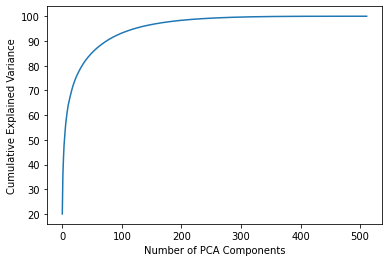

In [224]:
cum_component_variance = np.cumsum(pca_512.explained_variance_ratio_*100)
plt.plot(cum_component_variance)
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')

In [225]:
cum_component_variance[100]

93.20966759255559

In [226]:
pca_100 = PCA(n_components=100, random_state=4)
pca_100.fit(X)
X_pca = pca_100.transform(X)

In [227]:
clusters = [n for n in range(2,16)]
silhouette_coefficients = []

for cluster in clusters:
  kmeans = KMeans(n_clusters=cluster, random_state=420).fit(X_pca)
  labels = kmeans.labels_
  
  silhouette_avg = silhouette_score(X, labels)
  silhouette_coefficients.append(silhouette_avg)
  print("For n_clusters =",cluster, "The average silhouette_score is :",silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.1711378041504111
For n_clusters = 3 The average silhouette_score is : 0.20086387675307582
For n_clusters = 4 The average silhouette_score is : 0.1209936068495832
For n_clusters = 5 The average silhouette_score is : 0.12082600838525197
For n_clusters = 6 The average silhouette_score is : 0.11170913584291037
For n_clusters = 7 The average silhouette_score is : 0.10295322343193432
For n_clusters = 8 The average silhouette_score is : 0.10161360803501937
For n_clusters = 9 The average silhouette_score is : 0.08625026687232701
For n_clusters = 10 The average silhouette_score is : 0.09212637647064197
For n_clusters = 11 The average silhouette_score is : 0.09209920604298043
For n_clusters = 12 The average silhouette_score is : 0.12606663670178384
For n_clusters = 13 The average silhouette_score is : 0.0980974335152552
For n_clusters = 14 The average silhouette_score is : 0.1165894045692956
For n_clusters = 15 The average silhouette_score i

Text(0, 0.5, 'Silhouette Coefficients')

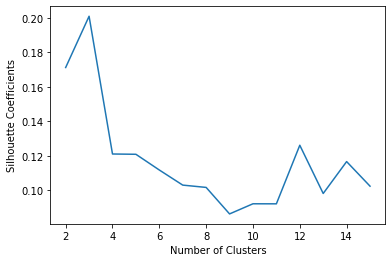

In [228]:
plt.plot(clusters, silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')

In [229]:
kmeans = KMeans(n_clusters=2, random_state=420).fit(X_pca)
cluster_labels = kmeans.labels_
print(f'There are {len(cluster_labels)} points, and {sum(cluster_labels)} points are in one cluster with {len(cluster_labels)-sum(cluster_labels)} in the other.')

There are 744 points, and 300 points are in one cluster with 444 in the other.


In [230]:
X_embedded = TSNE(n_components=2, random_state=4).fit_transform(X)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [235]:
# malignancy = list(map(lambda x:int(x), img_data[1]))
malignancy = list(map(lambda x:int(x), shuffle_data[1][744:]))

In [236]:
lidc_TSNE = pd.DataFrame()
lidc_TSNE['nodule_id'] = shuffle_id[744:]#lidc_cnnFeatures['nodule_id']
lidc_TSNE['cluster_label'] = cluster_labels
lidc_TSNE['component_1'] = X_embedded[:,0]
lidc_TSNE['component_2'] = X_embedded[:,1]
lidc_TSNE['malignancy'] = malignancy

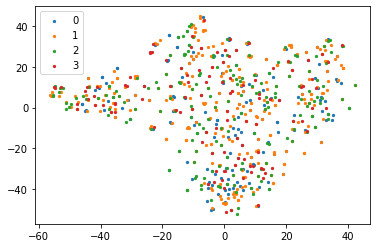

In [237]:
fig, ax = plt.subplots()
group = lidc_TSNE['malignancy']
component_1 = lidc_TSNE['component_1'].to_numpy()
component_2 = lidc_TSNE['component_2'].to_numpy()
# legend = {0:'red', 1:'blue'}

for g in np.unique(group):
    idx = np.where(group == g)
    ax.scatter(component_1[idx], component_2[idx],  label = g, s = 5) #c = legend[g],
ax.legend()
plt.show()